# Predicting Concrete Breaking Strength

#### Matt Williams, PE
#### April 18th, 2025

## 1.0 Introduction & Setup

### 1.1 Problem Statement

Concrete is a unique building material that has high compressive strength and relatively low tensile strength. A concrete mix is designed by engineers that specialize in creating a "recipe" to ensure certain material properties, one of which is the design strength.

The production of concrete starts by mixing the dry ingredients and then adding water to start a chemical reaction that causes it to cure. As concrete cures its strength increases. This is a non-linear development of strength whereby the concrete quickly develops strength and after this initial period, strength development slows down but still continues long after the hardened concrete goes into service.

This project seeks to build a machine learning model that can predict concrete breaking strength based on the mix ingredients and age of the sample by utilizing a dataset of 1030 samples of concrete. These samples were mixed, aged, and cast as test cylinders that were then crushed to determine the breaking strength of the sample. For each cylinder, the dataset includes the mix ingredient amounts, age of the cylinder, and the breaking strength.

### 2.2 Environment Setup

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import zscore
from scipy import stats
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.ensemble import AdaBoostRegressor as ada
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
import datetime
import seaborn as sns

### 2.2 Read Data into a Dataframe

For ease of processing the dataset is read into a pandas DataFrame. At the same time, a couple of the attribute names are shortened.

In [2]:
# Read customer churn data from csv file
df = pd.read_csv('concrete_data.csv')

# Rename 'blast_furnace_slag' & 'concrete_compressive_strength' for easier reading and referencing
df = df.rename(columns = {'blast_furnace_slag': 'slag', 'concrete_compressive_strength': 'strength'})

# Preview the Data
df.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


## 3. Data Exploration

### 3.1 Preview the Data

In [3]:
# View general statistics of numeric data
df.describe()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


### 3.2 Check for 'nan' Values

The first step in data exploration is to look for missing or 'nan' values.

In [4]:
# Look for 'nan' values per attribute
df.isna().sum()

cement              0
slag                0
fly_ash             0
water               0
superplasticizer    0
coarse_aggregate    0
fine_aggregate      0
age                 0
strength            0
dtype: int64

With no 'nan' values, the data can continue to be explored.

### 3.3 Check for Outliers

For this analysis, outliers will be taken as values that are more than 3 standard deviations from the mean. Data points this far from the mean can confuse the models. Outliers will be dealt with in section 4.0 Data Cleaning.

In [5]:
# Look for outliers
print('Number of z_scores > 3.0')
print('------------------------')
z_scores = df.apply(zscore)
print(z_scores[z_scores > 3].count())

Number of z_scores > 3.0
------------------------
cement               0
slag                 4
fly_ash              0
water                2
superplasticizer    10
coarse_aggregate     0
fine_aggregate       0
age                 33
strength             0
dtype: int64


### 3.4 Check for Colinearity

Colinearity is when attributes are linearly correlated to one another. Machine learning algorithms are used to determine the relationship of each attribute (independent variable) to the dependent variable. Any input variables that are correlated with one another are not independent and should be dealt with. The code block below creates and displays a correlation matrix to assess whether there is any colinearity among the attributes.

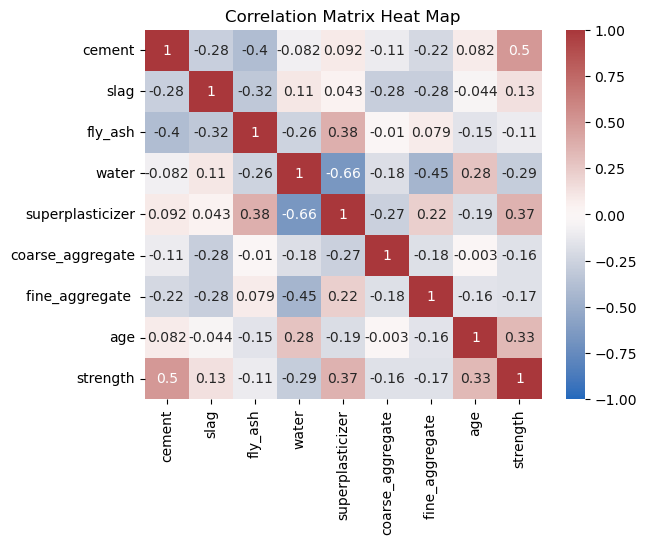

In [6]:
# Create the correlation matrix
matrix = df.corr(
    method = 'pearson')

# Plot correlation matrix & color by coefficient values
sns.heatmap(matrix, annot=True,
           vmax = 1,
           vmin = -1,
           center = 0,
           cmap = 'vlag');
plt.title('Correlation Matrix Heat Map');

The matrix above shows little correlation among the dependent variables save for those of water and superplasticizer. Also, there is very little linear correlation between the independent variables (mix ingredients) and the dependent variable (concrete strength). As such, a linear regression can be ruled out as a potential model to consider for this analysis.

### 3.5 Use Pair Plot to Look at Variable Relactions & Distributions

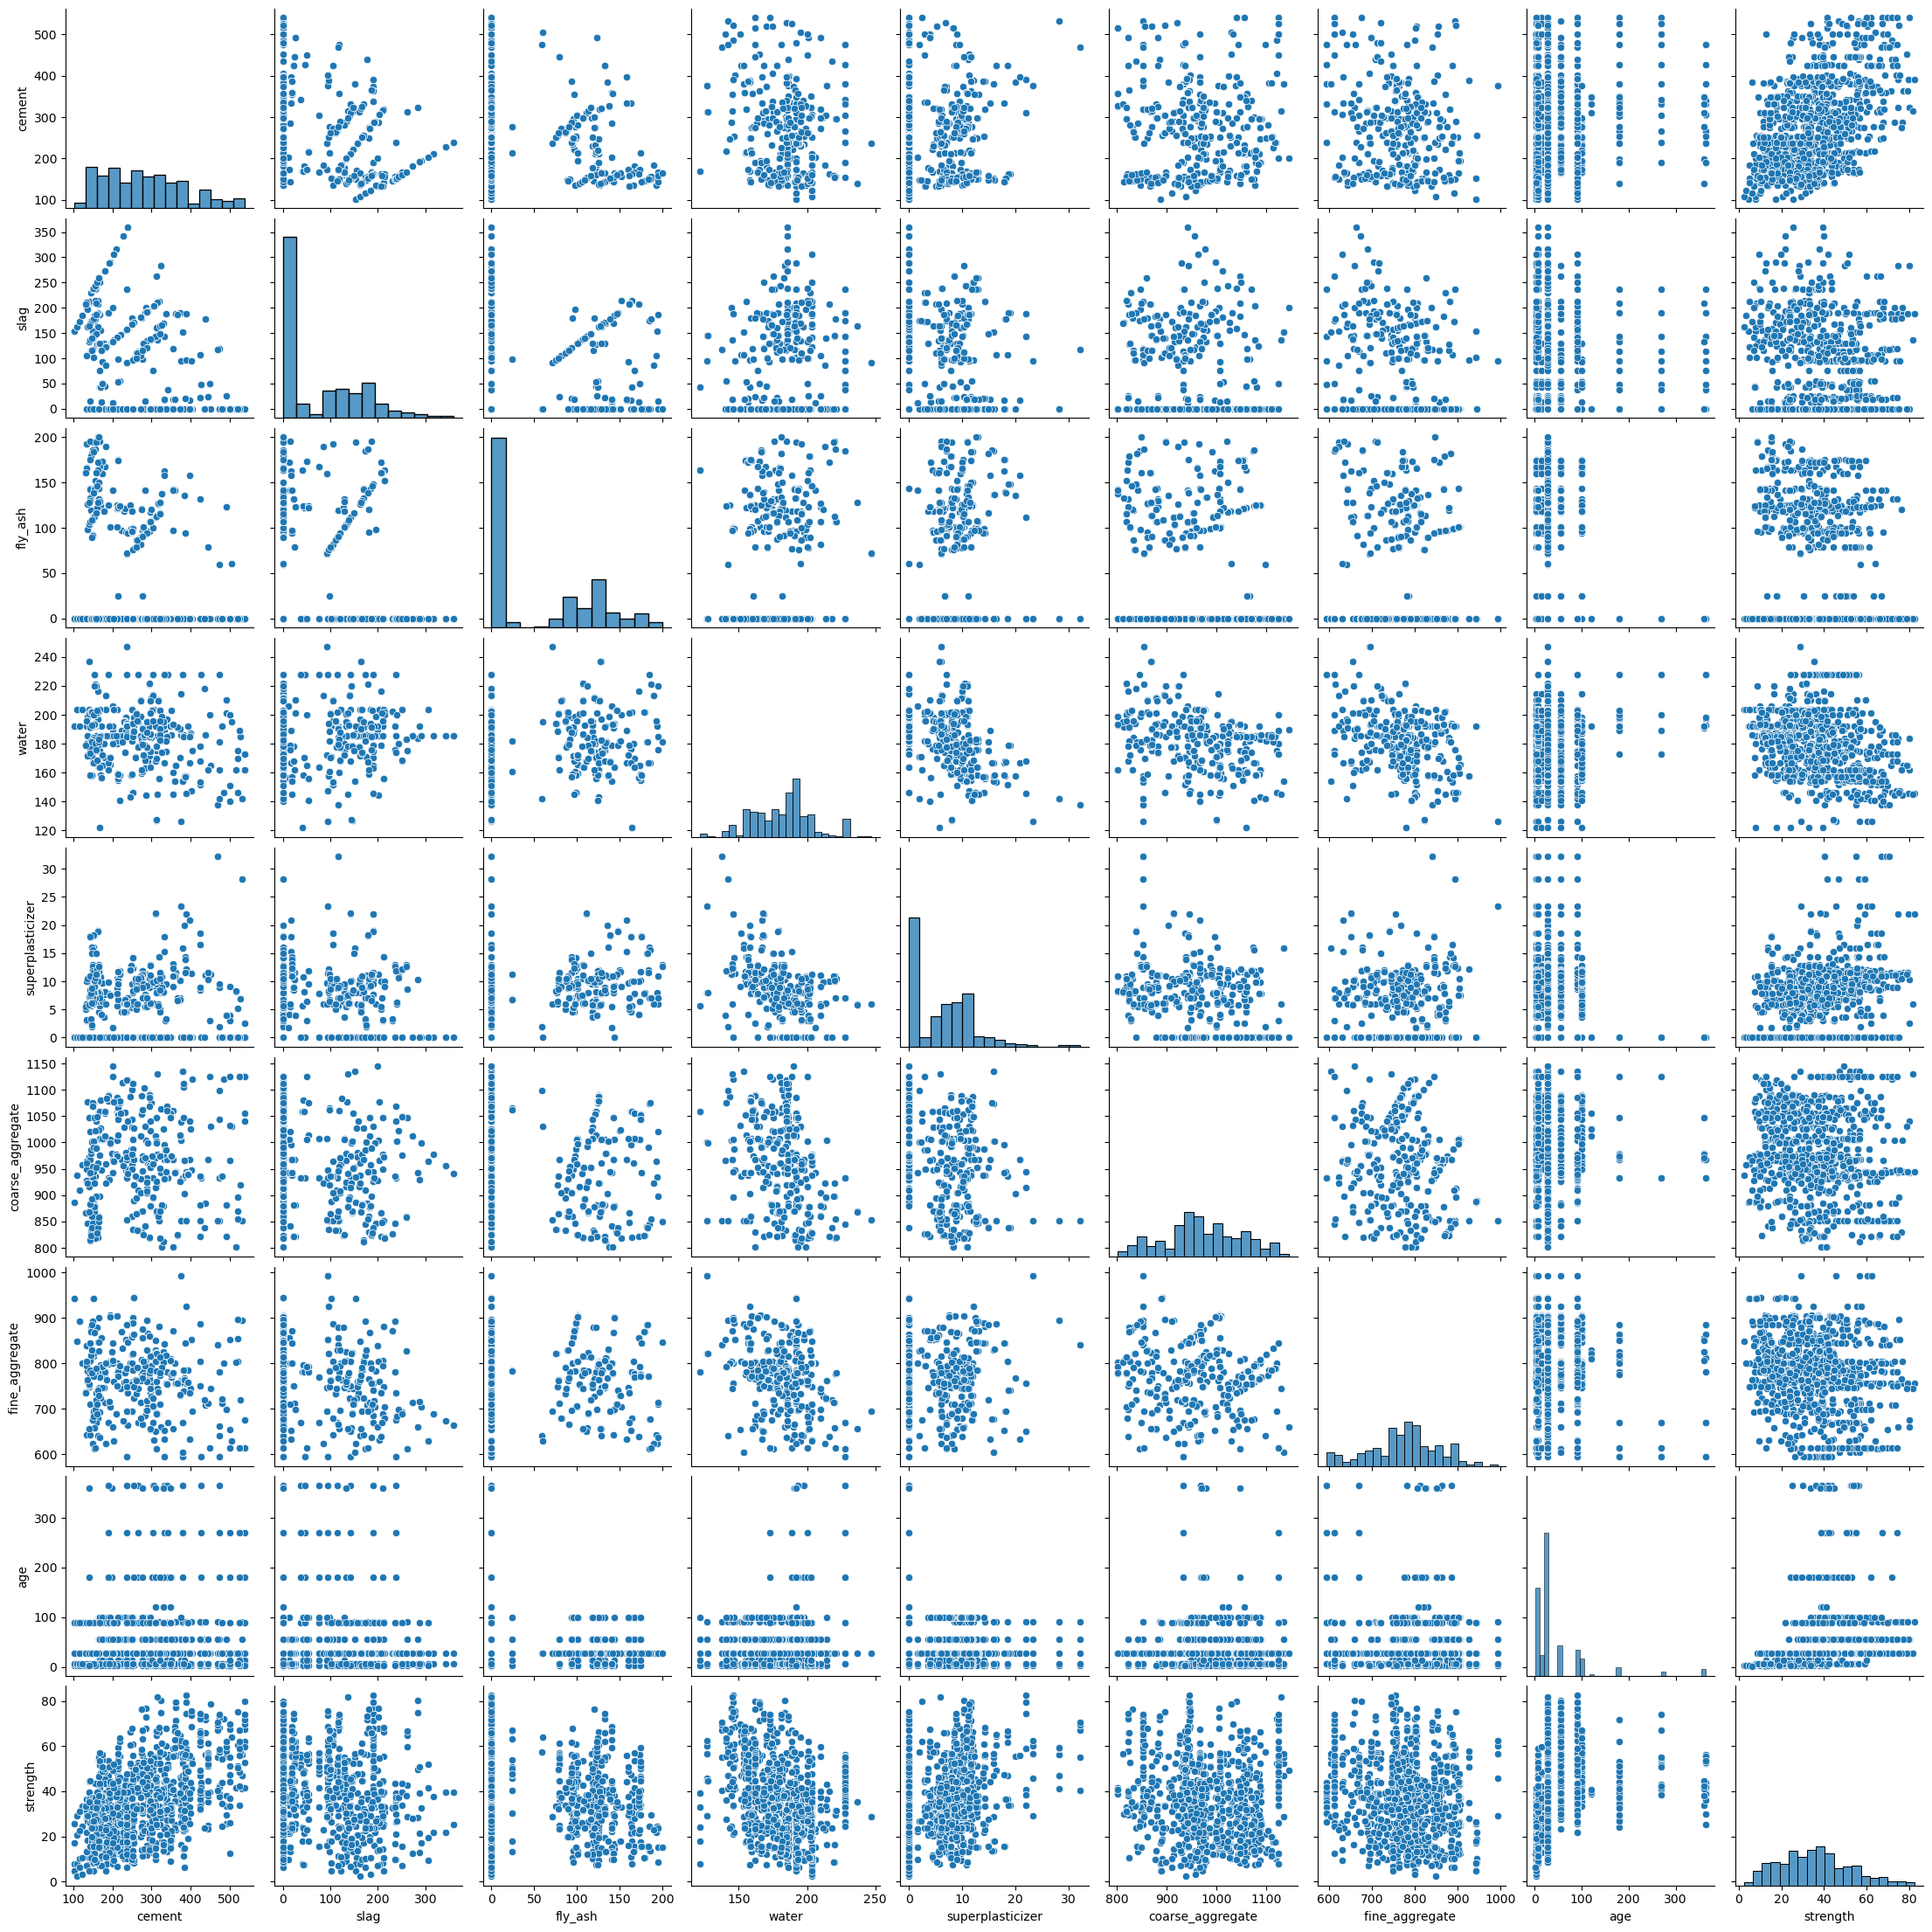

In [7]:
sns.pairplot(df);

## 4.0 Clean the Data

For this analysis, records containing outliers will be removed from the dataset for analysis. Outlying values could optionally be replaced with values that are within three standard deviations of the mean but because this dataset was a research dataset, the outliers may well have been accurate and intended to help inform the researchers on the effects of taking certain mix ingredients to extreme concentrations

In [8]:
print('Number of records before cleaning:', len(df))

# Drop records with attribute values greater than 3 standard deviations from the mean
df = df[(np.abs(stats.zscore(df))<3).all(axis=1)]

print('Number of records after dropping outliers:', len(df))

Number of records before cleaning: 1030
Number of records after dropping outliers: 981


## 5.0 Prepare the Data for Analysis

### 5.1 Split Data for Training & Testing

Using train_test_split from the scikit-learn library, split the data using 80% for training and 20% for testing.

In [9]:
# Create 'X'attribute inputs and 'y' labels
X = df.iloc[:,0:8]
y = df['strength']

# Split attributes and labels into training & testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# Create a dictionary to store model scores
results_dict = {}

### 5.2 Create a Scaled Copy of the Data

Both k-Nearest Neighbors and . This algorithm performs best with data that has been scaled. Here, a copy of the testing and training data is made and then scaled for with this algorithm.

In [10]:
# Scale the data for models that require it
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = pd.Series(df.columns)[0:8])
X_test_scaled = pd.DataFrame(X_test_scaled, columns = pd.Series(df.columns)[0:8])

## 6.0 Train & Compare Machine Learning Models to Predict Concrete Breaking Strength

### 6.1 Training & Testing Models

Here, I am initializing, training, and testing the following models on the customer churn data:

1. Decision Trees
2. Random Forest
3. k-Nearest Neighbors
4. Multilayer Perceptron (MLP/Neural Network)

For the most part, the models are used here with the defaults in order to get an idea of their baseline performance. From here, the best performing models will be developed further and go through hyperparameter tuning to maximize their accuracy.

In [11]:
# 1. Decision Tree Model
decision_tree = DecisionTreeRegressor(max_depth=5)
decision_tree.fit(X_train, y_train)
results_dict['Decision Tree'] = decision_tree.score(X_test, y_test)

# 2. Random Forest Model
random_forest = rfr(n_estimators = 100, max_depth=5, random_state=0)
random_forest.fit(X_train,y_train)
results_dict['Random Forest'] = random_forest.score(X_test, y_test)

# 3. k-Nearest Neighbors Regression
neighbors = []                                        # an empty list to store values for k
knn_score = []                                        # an empty list to store model scores
for i in range(1, 21, 1):                             # loop through k values
    knn = KNeighborsRegressor(n_neighbors = i)        # initialize the model
    knn = knn.fit(X_train_scaled, y_train)            # train the model
    knn_score.append(knn.score(X_test_scaled,y_test)) # calculate & store test score data
    neighbors.append(i)                               # store k value
max_index = knn_score.index(max(knn_score))           # find index of max model score
k = neighbors[max_index]                              # look up corresponding k value
results_dict['kNN Model'] = max(knn_score)

# 4. Multilayer Perceptron
mlp_model = MLPRegressor(random_state=0,
                          max_iter=3000,
                          alpha = 0.001,
                        ).fit(X_train_scaled, y_train)
results_dict['MLP Model'] = mlp_model.score(X_test_scaled, y_test)

# 5. AdaBoost
ada_regression = ada(random_state = 0, n_estimators = 100)
ada_regression.fit(X_train, y_train)
results_dict['AdaBoost'] = ada_regression.score(X_test, y_test)

### 6.2 Results Summary

With each of the machine learning models trained and tested, let's look at the results.

In [12]:
print('\n{:20s} {:>10s}'.format('Model', 'Score'))  # print header
print(31*'-')                                       # underline headers
for i in results_dict:                              # loop through results_dict to print models & scores
        print('{:20s} {:>10.3f}'.format(i, results_dict[i]))

# Print the name of the best performing model
print('\nThe best model for predicting concrete breaking strength is a', max(results_dict, key=results_dict.get)+'.')


Model                     Score
-------------------------------
Decision Tree             0.772
Random Forest             0.839
kNN Model                 0.745
MLP Model                 0.822
AdaBoost                  0.755

The best model for predicting concrete breaking strength is a Random Forest.


As output by the previous code block, the best performing model is the Random Forest with the multilayer perceptron model being a close second. In the next section, both of these algorithms will be tuned further to maximize accuracy.

Regarding the linear regression, this model performed quite poorly and this may be due to two factors. First, concrete strength development over time is inherently non-linear. Second, the correlation matrix in section 3.4 shows little linear correlation between the mix ingredients to the dependent variable (strength). The linear regression model was included here simply because it is a commonly used model but is an inappropriate choice given that there are no linear relationships among the independent variable and the dependent variable, concrete strength.

## 7.0 Model Tuning

### 7.1 Random Forest

To start the model tuning process, the contribution of each feature to the accuracy of the random forest model's predictions should be evaluated. Features with low importance can be dropped from the analysis both to make the model more efficient to run but also to reduce the potential for overfitting the model with features that aren't contributing much.

In [13]:
print('\n{:21s} {:>10s}'.format('Feature','Importance'))
print(32*'=')
feature_import = random_forest.feature_importances_
for i in range(len(feature_import)):
    print('{:21s} {:>10.3f}'.format(df.columns[i],feature_import[i],2))


Feature               Importance
cement                     0.299
slag                       0.066
fly_ash                    0.017
water                      0.085
superplasticizer           0.121
coarse_aggregate           0.006
fine_aggregate             0.020
age                        0.386


The table above shows the importance of each feature in the data set. For the purposes of this analysis, features with an importance of less than 0.05 are removed from the data. Thus fly_ash, coarse_aggregate, and fine_aggregate are removed and the model is refined based on the remaining features.

Now the random forest model is re-run to see the effect of dropping the least important features.

In [14]:
features = ['cement', 'slag', 'water', 'superplasticizer', 'age']

random_forest = rfr(n_estimators = 100, max_depth=5, random_state=0)
random_forest.fit(X_train_scaled[features],y_train)
results_dict['Random Forest'] = random_forest.score(X_test_scaled[features], y_test)

print('Tuned Random Forest Score:', round(random_forest.score(X_test_scaled[features], y_test),3))

Tuned Random Forest Score: 0.827


The model score suffered a marginal decrease by removing the features with the lowest importance. This decrease in accuracy is, however, an acceptable loss in order to avoid overfitting. In the next code block further tuning is done to see if the accuracy can be improved.

In [15]:
random_forest = rfr(n_estimators = 145,
                    max_depth = 12,
                    max_features = 'sqrt', # alternatives: 'sqrt', 'log2'
                    random_state=0)
random_forest.fit(X_train[features],y_train)

predictions = random_forest.predict(X_test[features])

print('Tuned Random Forest Score:', round(random_forest.score(X_test[features], y_test),3))

Tuned Random Forest Score: 0.891


Model performance has increased by increasing the decision tree depth limit and the number of trees used in the analysis.

### 7.2 Multilayer Perceptron

The MLP model below was tuned by specifying a new regularization term, alpha, and by adding hidden layers. The learning rate method was also set to 'constant'. Both alpha and the size of the hidden layers was varied until model performance was maximized. Alternative activation functions and solvers were also used but neither improved upon the model score.

In [16]:
mlp_model = MLPRegressor(random_state=0,
                          max_iter=3000,
                          solver = 'adam',
                          alpha = 0.001,
                          learning_rate = 'constant',
                          hidden_layer_sizes=(35,7)
                         ).fit(X_train_scaled, y_train)
print('Tuned Model Score:',round(mlp_model.score(X_test_scaled, y_test),3))
print('Number of Hidden Layers:', mlp_model.n_layers_)

Tuned Model Score: 0.848
Number of Hidden Layers: 4


## 8.0 Conclusion

This project shows that the best model performance was achieved by using a random forest. With more data, the model score of 0.891 could likely be improved upon. Below is a plot showing the predicted breaking strengths versus actual breaking strengths for the random forest model.

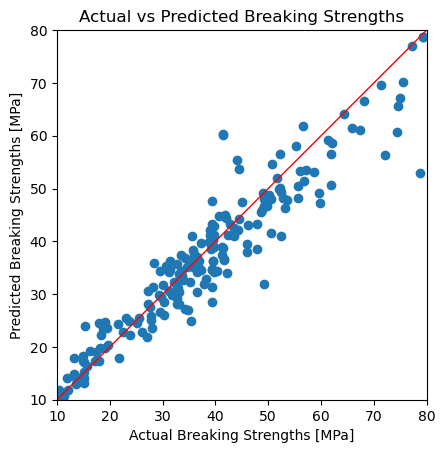

In [17]:
plt.scatter(y_test, predictions)
plt.plot([0,100],[0,100], color='red', linewidth=1)
plt.title('Actual vs Predicted Breaking Strengths')
plt.xlabel('Actual Breaking Strengths [MPa]')
plt.ylabel('Predicted Breaking Strengths [MPa]')
plt.axis('scaled')
plt.xlim(10, 80)
plt.ylim(10, 80)
plt.show()